In [17]:
import os
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [2]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()


['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [3]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])


['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


In [4]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [6]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [7]:
from cube.api import Cube
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
# nlp = spacy.load('en', disable=['parser', 'ner'])
nlp = spacy.load('en_core_web_sm')
# cube = Cube(verbose=True)
# cube.load("en")

# Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = lemmatization(data_words_bigrams)
data_lemmatized = lemmatization(data_words_bigrams[:20], allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['where', 'thing', 'car', 'nntp_poste', 'host', 'park', 'line', 'wonder', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


In [8]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 5), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1)]]


In [9]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('body', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('could', 1),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_poste', 1),
  ('park', 1),
  ('production', 1),
  ('really', 1),
  ('rest', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('spec', 1),
  ('sport', 1),
  ('thank', 1),
  ('thing', 1),
  ('where', 1),
  ('wonder', 1),
  ('year', 1)]]

In [10]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [11]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.025*"control" + 0.025*"access" + 0.025*"ncd" + 0.025*"boot" + '
  '0.025*"terminal" + 0.025*"file" + 0.017*"add" + 0.017*"system" + '
  '0.017*"list" + 0.017*"edit"'),
 (1,
  '0.002*"year" + 0.002*"go" + 0.002*"rate" + 0.002*"car" + 0.002*"be" + '
  '0.001*"make" + 0.001*"fast" + 0.001*"may" + 0.001*"live" + 0.001*"get"'),
 (2,
  '0.017*"call" + 0.017*"day" + 0.016*"name" + 0.016*"model" + 0.016*"see" + '
  '0.014*"info" + 0.012*"car" + 0.003*"early" + 0.003*"door" + '
  '0.003*"addition"'),
 (3,
  '0.029*"may" + 0.026*"child" + 0.026*"parent" + 0.016*"moral" + '
  '0.016*"swear" + 0.013*"morality" + 0.013*"think" + 0.013*"absolute" + '
  '0.013*"code" + 0.013*"know"'),
 (4,
  '0.001*"option" + 0.001*"year" + 0.001*"add" + 0.001*"power" + '
  '0.001*"capability" + 0.001*"flight" + 0.001*"car" + 0.001*"rate" + '
  '0.001*"insurance" + 0.001*"orbiter"'),
 (5,
  '0.050*"tiff" + 0.033*"image" + 0.017*"program" + 0.017*"application" + '
  '0.017*"complexity" + 0.011*"take" + 0.011

In [12]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.997787537271855

Coherence Score:  0.5523995593459048


## Visualize the topics-keywords

In [15]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

d:\python\envs\venv_telegram_analysis\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.182380 -0.177751       1        1  24.047659
15    -0.255700 -0.053352       2        1  18.319553
14     0.091030  0.070391       3        1  12.448349
3      0.072747  0.199201       4        1  10.978315
16    -0.034254  0.073868       5        1   6.435352
5      0.012345  0.024000       6        1   5.341424
8      0.000653  0.094215       7        1   4.378170
13    -0.016716 -0.042684       8        1   4.101042
10     0.038286 -0.046009       9        1   3.961987
11     0.003872 -0.016054      10        1   3.702839
0     -0.035243 -0.019912      11        1   2.818242
19     0.009288 -0.017411      12        1   1.687201
18    -0.007306 -0.021287      13        1   1.387357
2     -0.001853 -0.021695      14        1   0.272608
1     -0.000788 -0.009512      15        1   0.021926
17    -0.014023 -0.004019      16        1   0.020211
12    -0.008808 -0.009248      17        1   0.019711
9     -0.010876 -0.008978      18        1   0.019534
4     -0.014063 -0.009766      19        1   0.019263
7     -0.010970 -0.003995      20        1   0.019254, topic_info=    Category       Freq    Term      Total  loglift  logprob
4    Default  16.000000     car  16.000000  30.0000  30.0000
39   Default  26.000000    year  26.000000  29.0000  29.0000
382  Default  12.000000    scsi  12.000000  28.0000  28.0000
324  Default   9.000000  weapon   9.000000  27.0000  27.0000
666  Default  14.000000  option  14.000000  26.0000  26.0000
..       ...        ...     ...        ...      ...      ...
341  Topic20   0.000454   think   9.079511  -1.3491  -6.9167
87   Topic20   0.000456      be  17.970100  -2.0255  -6.9103
21   Topic20   0.000453    make  10.463504  -1.4933  -6.9190
4    Topic20   0.000452     car  16.959423  -1.9784  -6.9212
109  Topic20   0.000448     get   9.571321  -1.4139  -6.9287

[1183 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
817       3  0.696648      able
817       6  0.348324      able
461       4  0.795330  absolute
818       6  0.868381     abuse
444       8  0.915265     accel
...     ...       ...       ...
39        1  0.874183      year
39        5  0.038008      year
39        6  0.038008      year
39        9  0.038008      year
39       10  0.038008      year

[891 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 16, 15, 4, 17, 6, 9, 14, 11, 12, 1, 20, 19, 3, 2, 18, 13, 10, 5, 8])

In [18]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
os.environ.update({'MALLET_HOME':r'D:/libs/mallet-2.0.8/'})
mallet_path = 'D:/libs/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [19]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(1,
  [('man', 0.05434782608695652),
   ('post', 0.05434782608695652),
   ('hit', 0.043478260869565216),
   ('line', 0.043478260869565216),
   ('give', 0.043478260869565216),
   ('info', 0.043478260869565216),
   ('deductible', 0.03260869565217391),
   ('pretty', 0.03260869565217391),
   ('feel', 0.021739130434782608),
   ('price', 0.021739130434782608)]),
 (11,
  [('line', 0.09),
   ('day', 0.06),
   ('hear', 0.05),
   ('end', 0.04),
   ('machine', 0.04),
   ('error', 0.04),
   ('opinion', 0.04),
   ('suppose', 0.03),
   ('display', 0.03),
   ('computer', 0.03)]),
 (8,
  [('question', 0.13114754098360656),
   ('organization', 0.06557377049180328),
   ('memory', 0.04918032786885246),
   ('fix', 0.04918032786885246),
   ('basically', 0.03278688524590164),
   ('bug', 0.03278688524590164),
   ('paint', 0.01639344262295082),
   ('cry', 0.01639344262295082),
   ('owner', 0.01639344262295082),
   ('sheet', 0.01639344262295082)]),
 (14,
  [('thing', 0.0963855421686747),
   ('case', 0.0361445

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

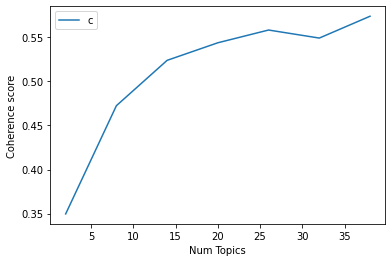

In [21]:
import matplotlib.pyplot as plt
#Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [22]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3496
Num Topics = 8  has Coherence Value of 0.4724
Num Topics = 14  has Coherence Value of 0.5238
Num Topics = 20  has Coherence Value of 0.5438
Num Topics = 26  has Coherence Value of 0.5582
Num Topics = 32  has Coherence Value of 0.5491
Num Topics = 38  has Coherence Value of 0.5739


In [23]:

# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.058*"control" + 0.058*"access" + 0.035*"boot" + 0.035*"terminal" + '
  '0.035*"ncd" + 0.035*"great" + 0.023*"amplify" + 0.023*"configuration" + '
  '0.023*"entry" + 0.023*"network"'),
 (1,
  '0.094*"day" + 0.078*"clock" + 0.078*"speed" + 0.062*"si" + 0.047*"reply" + '
  '0.031*"poll" + 0.031*"upgrade" + 0.016*"phone" + 0.016*"request" + '
  '0.016*"negligent"'),
 (2,
  '0.097*"line" + 0.081*"hear" + 0.065*"suppose" + 0.065*"error" + '
  '0.048*"display" + 0.048*"back" + 0.032*"memory" + 0.032*"price" + '
  '0.032*"post" + 0.016*"osterizer"'),
 (3,
  '0.058*"change" + 0.043*"hand" + 0.043*"decide" + 0.043*"cost" + '
  '0.029*"pretty" + 0.029*"create" + 0.029*"bug" + 0.029*"standard" + '
  '0.029*"sport" + 0.014*"standardize"'),
 (4,
  '0.137*"write" + 0.118*"article" + 0.118*"weapon" + 0.039*"mass_destruction" '
  '+ 0.029*"modern" + 0.029*"division" + 0.029*"point" + 0.029*"individual" + '
  '0.029*"hard" + 0.020*"tavare"'),
 (5,
  '0.072*"opinion" + 0.072*"make" + 0.058*"goo

In [24]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [25]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)],
                                            axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.3536,"control, access, boot, terminal, ncd, great, a...",From: (Ann Marie Barden) Subject: X-Terminal C...
1,1.0,0.2249,"day, clock, speed, si, reply, poll, upgrade, p...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,4.0,0.3390,"write, article, weapon, mass_destruction, mode...",From: (Foxvog Douglas) Subject: Re: Rewording ...
3,7.0,0.3763,"image, tiff, term, read, complexity, understan...",From: (Allen B) Subject: Re: TIFF: philosophic...
4,8.0,0.4640,"year, car, rate, insurance, live, high, record...",From: (Kevin Parker) Subject: Insurance Rates ...


In [26]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,8.0,"year, car, rate, insurance, live, high, record...",1.0,0.05
1.0,1.0,"day, clock, speed, si, reply, poll, upgrade, p...",1.0,0.05
2.0,15.0,"question, people, machine, info, organization,...",NaN,NaN
3.0,4.0,"write, article, weapon, mass_destruction, mode...",NaN,NaN
4.0,15.0,"question, people, machine, info, organization,...",2.0,0.10
...,...,...,...,...
11309.0,NaN,NaN,NaN,NaN
11310.0,NaN,NaN,NaN,NaN
11311.0,NaN,NaN,NaN,NaN
11312.0,NaN,NaN,NaN,NaN
